In [1]:
import tensorflow as tf
import numpy as np

# Approximate sine wave

In [12]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

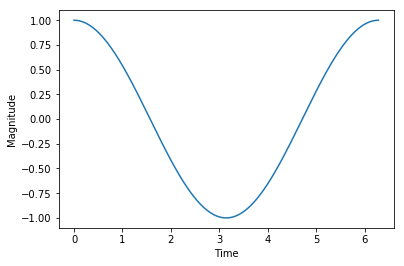

In [14]:
t = np.linspace(0.0, 360.0, 10000)*(np.pi/180.0)
y = np.cos(t)
plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.show()

In [4]:
# Set up the network as the tf.estimator

In [52]:
class network():
    def __init__(self,
                input_states,
                num_layers,
                nurons_list,
                output_states,
                session):
        
        # Check if the number of neurons in each layer is 
        if len(nurons_list) != num_layers:
            raise ValueError("nurons_list != num of layers")
        
        #Initalize the session
        self.session = session
        
        # Initialize the network
        self.input_states = tf.placeholder(dtype=tf.float64, shape=[None, input_states])
        self.target_states = tf.placeholder(dtype=tf.float64, shape=[None, output_states])
        
        # Create a dictonary of weight and states based on the input layers
        # Compute the dimentions of the weight bias matrix
        self.network_depth = num_layers
        
        nurons_list.append(output_states)
        nurons_list = [input_states] + nurons_list
        
        self.network_width = nurons_list # list of nurons in each layer including input and output 
        
        self.weights_bias = {}
        for i in range(0, self.network_depth+1):
            self.weights_bias["w"+str(i)] = tf.Variable(np.random.rand(self.network_width[i], self.network_width[i+1]), dtype=tf.float64)
            self.weights_bias["b"+str(i)] = tf.Variable(np.random.rand(self.network_width[i+1]), dtype=tf.float64)
        
        
        # Set the computation graph for the network
        self.forward_pass = {}
        # First layer
        self.forward_pass["z1"] = tf.tensordot(self.input_states, self.weights_bias["w0"], axes=1) + self.weights_bias["b0"]
        self.forward_pass["y1"] = tf.nn.relu(self.forward_pass["z1"]) # Make this a user choice 
        
        for i in range(2, self.network_depth+1):
            self.forward_pass["z"+str(i)] = tf.tensordot(self.forward_pass["y"+str(i-1)],
                                                         self.weights_bias["w"+str(i-1)],
                                                         axes=1) + self.weights_bias["b"+str(i-1)]
            self.forward_pass["y"+str(i)] = tf.nn.relu(self.forward_pass["z"+str(i)])
            
        # Final Layer with out activation
        self._predict = tf.tensordot(self.forward_pass["y"+str(self.network_depth)],
                                    self.weights_bias["w"+str(self.network_depth)],
                                    axes=1) + self.weights_bias["b"+str(self.network_depth)]
        
        # Loss function
        self.loss = tf.reduce_mean(tf.square(self._predict - self.target_states))
        
        # Optimizer 
        self.optimizer = tf.train.AdamOptimizer()
        
        # Training
        self._train = self.optimizer.minimize(self.loss)
        
        # Initialize the variables 
        self.session.run(tf.global_variables_initializer())
        
    def predict_on_batch(self, input_states):
        return self.session.run(self._predict, {self.input_states:input_states})
    
    def fit(self, inp_states, tar_states):
        self.session.run(self._train, {self.input_states:inp_states, self.target_states:tar_states})
        # Return loss function.
    
    def save_weights(self, path):
        data = {}
        for i in range(0, self.network_depth+1):
            data["w"+str(i)] = self.session.run(self.weights_bias["w"+str(i)])
            data["b"+str(i)] = self.session.run(self.weights_bias["b"+str(i)])
        np.save(path, data)
        print("Weights Saved to ", path)

    def set_weights(self, weigths_bias_load):
        # Make sure the width and depth are equal 
        for i in range(0, self.network_depth+1):    
            self.session.run(self.weights_bias["w"+str(i)].assign(weigths_bias_load["w"+str(i)]))
            self.session.run(self.weights_bias["b"+str(i)].assign(weigths_bias_load["b"+str(i)]))

In [53]:
nn = network(input_states=1, num_layers=2, nurons_list=[20, 20], output_states=1, session=tf.Session())

In [45]:
theta_np = np.linspace(0.0, 360.0, 10000)*((3.14)/180.0)
for i in range(10000):
    tr = np.random.choice(np.linspace(0, 9999, 9999, dtype=int), 32)
    temp = np.asarray([theta_np[i] for i in tr])
    temp = temp.reshape(32, 1)
    nn.fit(temp, np.cos(temp))
    l = nn.session.run(nn.loss, {nn.input_states:temp, nn.target_states:np.cos(temp)})
    if i%10000 == 0:
        print("loss: %s"%(l))
nn.save_weights("./data/cos.npy")

loss: 57340.2637416


In [46]:
theta_np = theta_np.reshape(10000,1)
y = nn.predict_on_batch(theta_np)

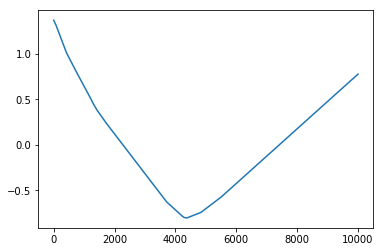

In [47]:
plt.plot(y)
plt.show()

In [48]:
nn1 = network(input_states=1, num_layers=2, nurons_list=[20, 20], output_states=1, session=nn.session)

In [49]:
nn1.set_weights(weigths_bias_load=np.load("./data/cos.npy").item())

In [50]:
theta_np = theta_np.reshape(10000,1)
y = nn1.predict_on_batch(theta_np)

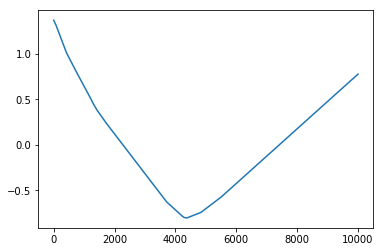

In [51]:
plt.plot(y)
plt.show()